In [1]:
%cd /content/drive/MyDrive/Arash

/content/drive/MyDrive/Arash


In [2]:
from numpy import pi
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import glob
from tqdm import tqdm

import skimage
from skimage import morphology
from skimage.morphology import convex_hull_image
from skimage.measure import label, regionprops, regionprops_table
from skimage.feature import canny
from scipy import ndimage as ndi

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

plt.style.use ('seaborn')

In [3]:
ver= 8
cnn_step= 2

# Make Masks

In [4]:
# Load CNN model

def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - numerator / denominator

# model = load_model ('CNN1_v1(Best).model', custom_objects={"dice_loss": dice_loss})
model = load_model (f'CNN{cnn_step}_v{ver}.model', custom_objects={"dice_loss": dice_loss})

In [5]:
IMAGES= glob.glob('**/data/**.tif')
len(IMAGES)

1883

In [6]:
df_IMAGES = pd.DataFrame({
    'filename': IMAGES,
})
df_IMAGES.head(20)

,filename
0,Adipo/data/Adipo_0.5_18_Tv57.tif
1,Adipo/data/Adipo_0.5_18_Tv58.tif
2,Adipo/data/Adipo_0.5_18_Tv59.tif
3,Adipo/data/Adipo_0.5_18_Tv60.tif
4,Adipo/data/Adipo_0.5_6_Tv46.tif
5,Adipo/data/Adipo_0.5_6_Tv47.tif
6,Adipo/data/Adipo_0.5_6_Tv51.tif
7,Adipo/data/Adipo_0.5_6_Tv49.tif
8,Adipo/data/Adipo_0.5_6_Tv52.tif
9,Adipo/data/Adipo_0.5_6_Tv50.tif


In [9]:
INPUT_WIDTH = 512
INPUT_HEIGHT = 688
INPUT_SIZE = (INPUT_WIDTH, INPUT_HEIGHT)

IMAGE_CHANNELS=3

In [10]:
test_datagen = ImageDataGenerator(
    rescale=1./255,
)

batch_size= 16
seed= 100

datagen = test_datagen.flow_from_dataframe(
    df_IMAGES, 
    x_col='filename',
    target_size= INPUT_SIZE,
    class_mode=None,
    batch_size=batch_size,
    # seed=seed,
    shuffle=False,
)

Found 1883 validated image filenames.


In [11]:
# Function for binerization and small modifications on model outputs to make readable masks. 

eccent_c= 0.89
def mask (image): 
    edges = canny(image, sigma= 4)
    canny_fill = ndi.binary_fill_holes(edges)
    msk= morphology.remove_small_objects(canny_fill, 160)
    return msk

1/1 [==============================] - 16s 16s/step


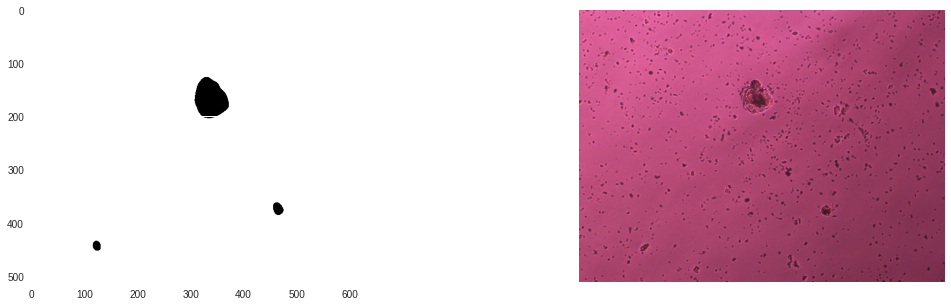

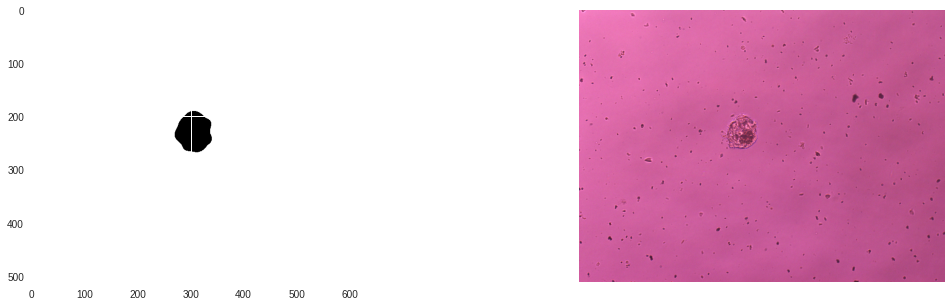

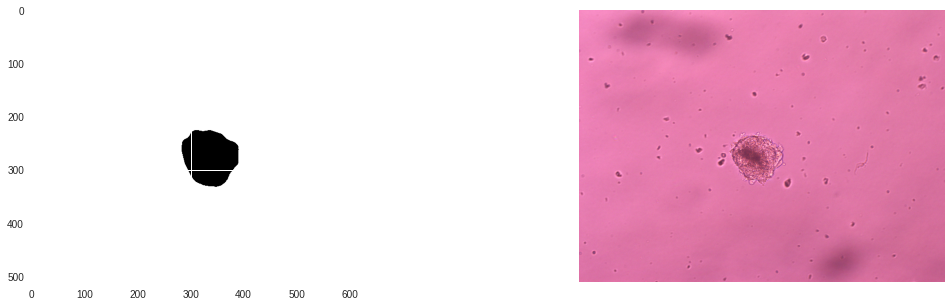

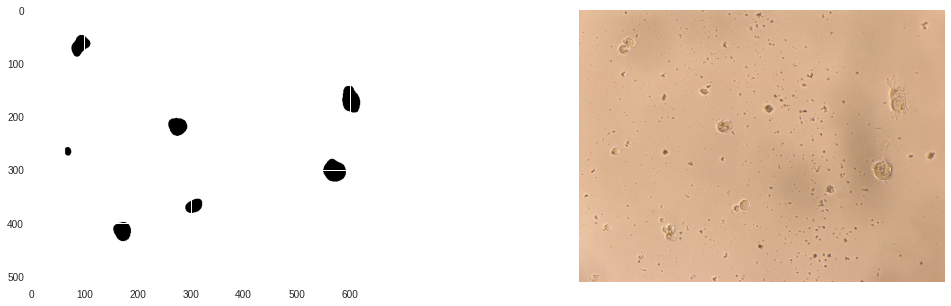

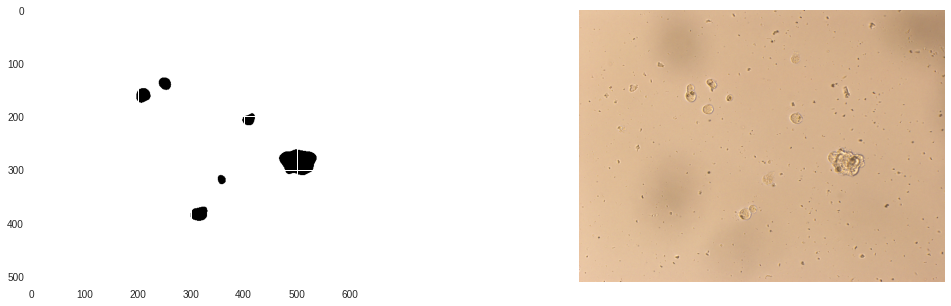

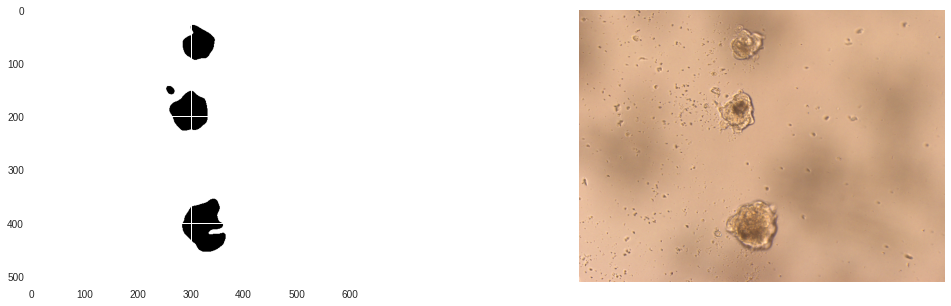

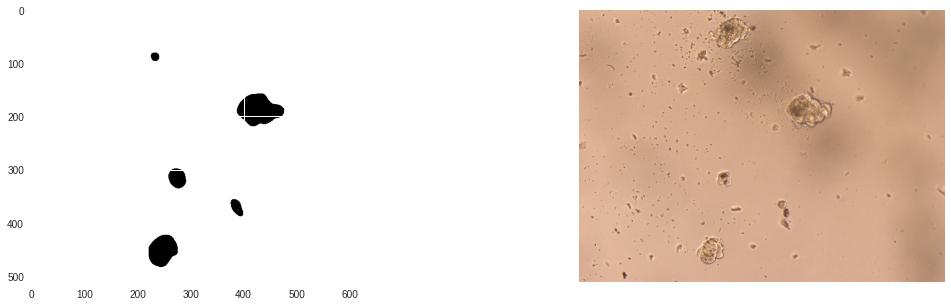

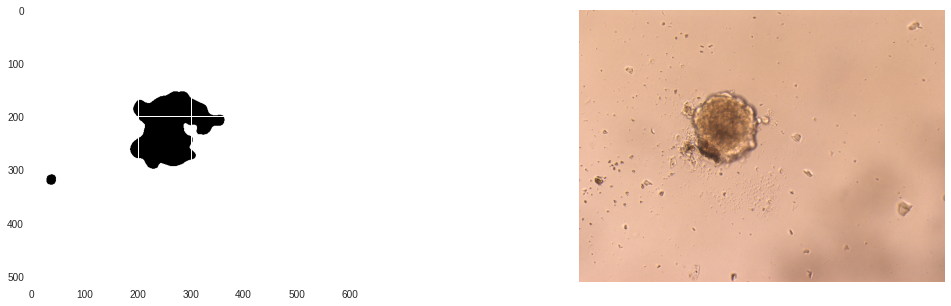

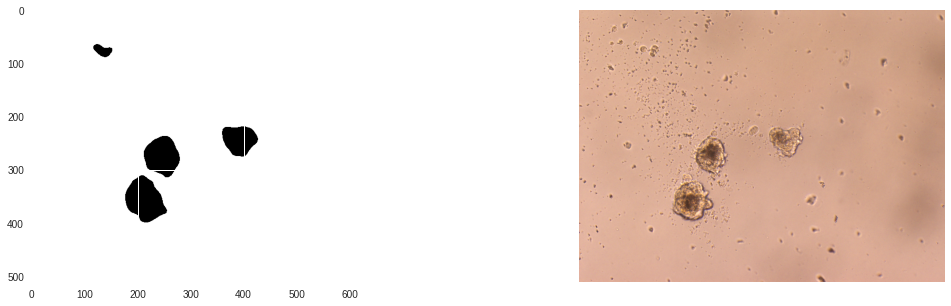

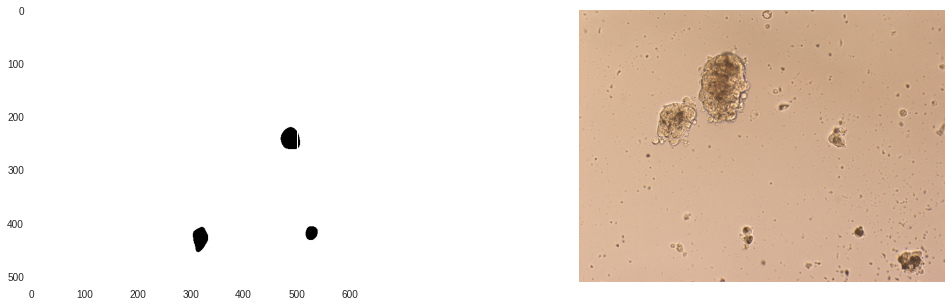

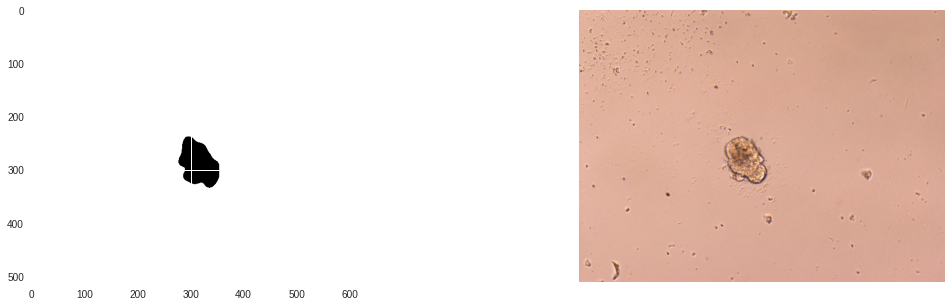

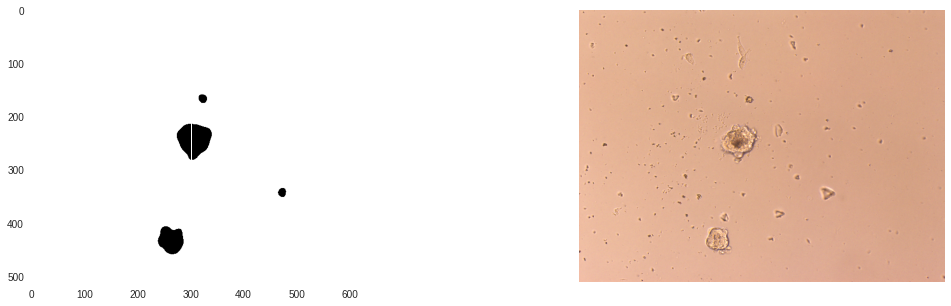

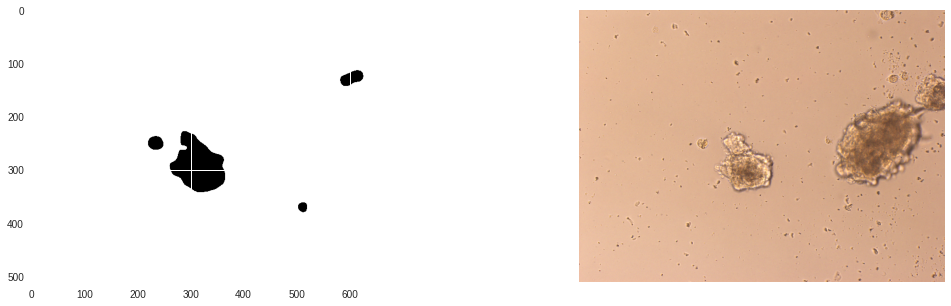

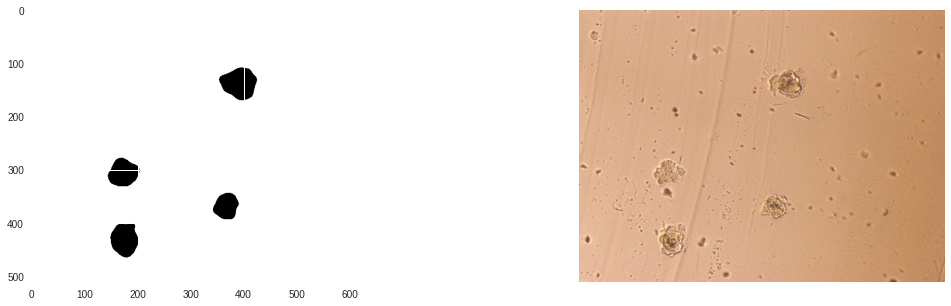

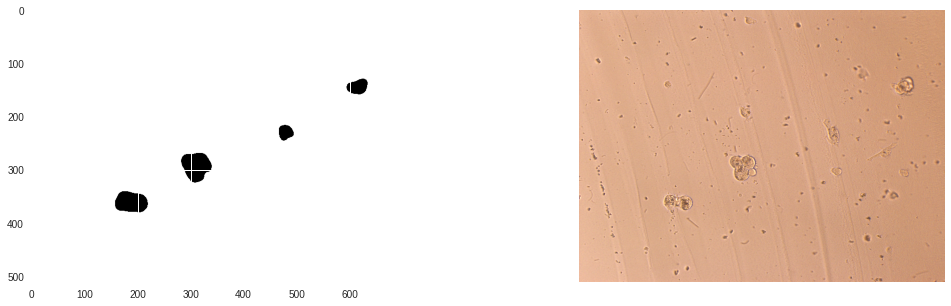

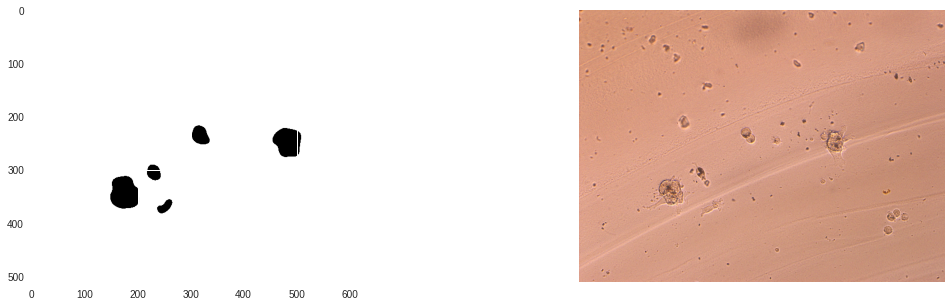

In [14]:
# Sample Visualization, 

###### IMPORTANT: COMMENT THIS CELL WHEN YOU ARE GOING TO SAVE MASKS ON THE NEXT CELL. RUNNING THIS BEFOREHEAD MIGHT RESULT IN INCONVENIENCE.

for c in range(0, len(IMAGES[:12]), batch_size):
    batch= datagen.next()
    images_pred= model.predict (batch)
    images_pred= images_pred.reshape (images_pred.shape [:3])
    names= datagen.filenames[c:c+batch_size]
    for i,img in enumerate(images_pred):
        msk= mask(img)

        label_img = label(msk)
        regions= regionprops(label_img)
        benchmark= [regions[k].eccentricity < eccent_c for k in range (len (regions))]
        for j, ben in enumerate(benchmark):
            if not ben:
                label_img[label_img == j+1] = 0
        msk= label_img.astype (bool)

        name= names[i].split('.tif')[0]

        fig, ax= plt.subplots(1,2,figsize=[18,5])

        ax[0].imshow(msk);
        ax[1].imshow(batch[i]);

        plt.axis('off')

In [ ]:
###### IMPORTANT: IF YOU HAVE PREV. CELL, RESTART RUNTIME, COMMENT IT, THEN START RUNNING CELLS FROM ABOVE, 
###### OTHERVISE, YOU MIGHT FACE INCONVENIENT RESULTS.


for c in range(0, len(IMAGES), batch_size):
    batch= datagen.next()
    images_pred= model.predict (batch)
    images_pred= images_pred.reshape (images_pred.shape [:3])
    names= datagen.filenames[c:c+batch_size]
    for i,img in enumerate(images_pred):
        msk= mask(img)

        label_img = label(msk)
        regions= regionprops(label_img)
        benchmark= [regions[k].eccentricity < eccent_c for k in range (len (regions))]
        for j, ben in enumerate(benchmark):
            if not ben:
                label_img[label_img == j+1] = 0
        msk= label_img.astype (bool)

        name= names[i].split('.tif')[0]
        # np.save (f'{name}', msk.astype (bool))

        fig= plt.figure()
        ax= fig.add_axes ([0,0,1,1])
        ax.set_xticks ([])
        ax.set_yticks ([])
        plt.axis('off')
        ax.imshow(msk);
        plt.savefig(f'{name}_msk{ver}.png', dpi=fig.dpi)
        plt.close('all')
        del msk
    print (c)